In [73]:
import pandas as pd
import numpy as np
import re
import torch

## Word Tokenizer

In [271]:
class OneHotEncoder:
    def __init__(self, sos="<s>", eos="</s>", oob="UNK"):
        self.sos = sos
        self.eos = eos
        self.oob = oob
        self.text_to_index = {}
        self.index_to_text = {}
        self.text_to_count = {}

    def fit_on_texts(self, text: str | list, max_num_of_elems=None):
        """"
        Text either as list of words (word embedding) or string (character embedding)
        """
        for elem in text:
            self.text_to_count[elem] = self.text_to_count.get(elem, 0) + 1
        

        if max_num_of_elems is None:
            max_num_of_elems = len(self.text_to_count)
        
        self.text_to_index = {self.eos: 0, self.sos: 1, self.oob: 2}
        index = len(self.text_to_index)

        sorted_texts_by_counts = sorted(self.text_to_count.items(), key=lambda x: x[1], reverse=True)[:max_num_of_elems]
        for elem in [item[0] for item in sorted_texts_by_counts]:
            self.text_to_index[elem] = index
            index += 1

        self.index_to_text = {index: text for text, index in self.text_to_index.items()}
        

    def encode(self, text: str | list) -> torch.Tensor:
        encoding_list = [self.text_to_index.get(elem, self.text_to_index[self.oob]) for elem in text]
        return torch.tensor(encoding_list)


    def decode(self, embedding: torch.Tensor) -> list[str]:
        decoding_list = [self.index_to_text[elem] for elem in embedding.tolist()]
        return decoding_list

In [3]:
ohc = OneHotEncoder()
text = "This is a random text"
tokenized = re.sub("[^a-zA-Z+ ]", "", text).split()
ohc.fit_on_texts(tokenized)
ohc.decode(ohc.encode(tokenized))

['This', 'is', 'a', 'random', 'text']

## Load and preprocess dataset

In [231]:
def normalize_sentence(sentence: str, lowercase=False):
    sentence = sentence.strip()
    if lowercase:
        sentence = sentence.lower()
    
    # Remove structure information in stylistic texts
    sentence = re.sub("V?I{1,3}\.", "", sentence)
    sentence = re.sub("^[a-gA-D123456]\)", "", sentence)

    # Remove hyper-links
    sentence = re.sub("https?\S+", "", sentence)
    sentence = re.sub("www\S+", "", sentence)

    # Remove emoticons
    sentence = re.sub("[:;\.=xX<][^a-zA-Z\s]*o*[\)\(\/oDP!3]+", "", sentence)
    sentence = re.sub('["#$%&()*+\-\/;=@[\]^_`{|}~\t\n]+', "", sentence)

    # Use separate tokens for interpunction
    sentence = re.sub("\.+", " .", sentence)
    sentence = re.sub(",+", " ,", sentence)
    sentence = re.sub(":+", " :", sentence)
    sentence = re.sub("\?+", " ?", sentence)
    sentence = re.sub("!+", " !", sentence)
    sentence = re.sub("  ", " ", sentence)
    return sentence.strip().split(" ")

In [232]:
def tokenize_dataset(data_type="train"):
    with open(f"data/{data_type}/sentence.input", encoding="UTF-8") as input_file:
        input_lines = input_file.readlines()
    
    with open(f"data/{data_type}/sentence.gold", encoding="UTF-8") as input_file:
        golden_lines = input_file.readlines()

    input_tokens = []
    gold_tokens = []
    for input_line, golden_line in zip(input_lines, golden_lines):
        for golden_choice in golden_line.split("\t"):
            normalized_choice = normalize_sentence(golden_choice, lowercase=False)

            if len(normalized_choice) > 3 or len(normalized_choice[0]) > 4:
                input_tokens.append(normalize_sentence(input_line, lowercase=False))
                gold_tokens.append(normalized_choice)

    return input_tokens, gold_tokens

In [233]:
train_input, train_golden = tokenize_dataset("train")

### Dataset analysis

In [234]:
train_input_flattened = np.concatenate(train_input).ravel()
train_golden_flattened = np.concatenate(train_golden).ravel()

In [235]:
from collections import Counter
import matplotlib.pyplot as plt

In [236]:
ct = Counter(train_input_flattened)

In [237]:
print("Number of tokens: ", len(train_input_flattened))
print("Number of types (unique tokens):", len(ct.keys()))
print("Most common tokens: \n\t", "\n\t".join(map(str, ct.most_common(25))))

Number of tokens:  808463
Number of types (unique tokens): 79496
Most common tokens: 
	 ('.', 56722)
	(',', 42236)
	('a', 26761)
	('se', 17040)
	('na', 13326)
	('je', 12132)
	('v', 10066)
	('to', 8933)
	('jsem', 8552)
	('že', 6933)
	('do', 5755)
	('si', 4993)
	('s', 4355)
	('ale', 3805)
	('tak', 3686)
	('?', 3672)
	('jsme', 3596)
	('mi', 3085)
	('A', 2920)
	('bych', 2852)
	('z', 2842)
	('tam', 2697)
	('o', 2696)
	('!', 2505)
	('moc', 2419)


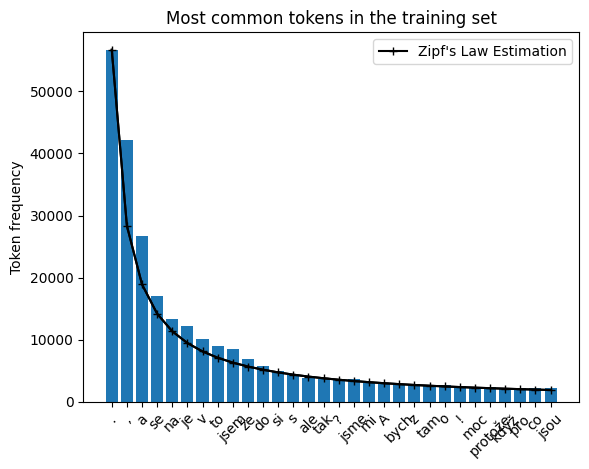

In [238]:
x, y = list(zip(*ct.most_common(30)))
zipf_y = [(1/n**1) * y[0] for n in range(1, len(x) + 1)]

plt.bar(x, y)
plt.plot(x, zipf_y, color="black")
plt.plot(x, zipf_y, color="black", marker="+", label="Zipf's Law Estimation")
plt.legend()
plt.xticks(rotation=45)
plt.ylabel("Token frequency")
plt.title("Most common tokens in the training set")
None

In [239]:
sorted_values = sorted(ct.items(), key=lambda x: x[1], reverse=True)

In [240]:
percentile = 0.6
counts = np.array(list(reversed([x[1] for x in sorted_values])))
count_treshold = np.quantile(counts, 1 - percentile)

print(f"{percentile} percentile (word frequency): {count_treshold:.0f}")
print(f"Number of tokens below the {percentile} percentile: ", len([x for x in counts if x > count_treshold]))
print(f"Number of tokens above the {percentile} percentile: ", len([x for x in counts if x <= count_treshold]))


0.6 percentile (word frequency): 1
Number of tokens below the 0.6 percentile:  45316
Number of tokens above the 0.6 percentile:  34180


### Tensor creation

In [257]:
from torch.nn.utils.rnn import pad_sequence

In [276]:
tokenizer = OneHotEncoder()
tokenizer.fit_on_texts(np.concatenate([train_input_flattened, train_golden_flattened]))

In [277]:
train_input_tensor = pad_sequence([tokenizer.encode(sentence) for sentence in train_input])

In [278]:
tokenizer.decode(train_input_tensor.transpose(0, 1)[2])

['Nebo',
 'nevím',
 'nějaké',
 'specifiské',
 'běloruské',
 'národní',
 'tradice',
 ',',
 'protože',
 'vyrostl',
 'jsem',
 've',
 'městě',
 ',',
 'kde',
 'oslává',
 'Vánoc',
 'neni',
 'tak',
 'rozšiřena',
 '.',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>